[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/global_local_modeling.ipynb)


# Global Local Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

When many time series share only "some behaviour" we will need a **global local model**. In the following notebook we will see an example of time series sharing behaviour/weights on all the components except from the trend and seasonality. Therefore, we will also build a global local model using data from the hourly load of the ERCOT region.

This notebook is an adaptation of `global_modeling.ipynb`.

First, we load the data:

In [1]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

set_random_seed(10)
set_log_level("ERROR", "INFO")

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32


We extract the name of the regions which will be later used in the model creation.

In [3]:
regions = list(df_ercot)[1:]

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [4]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[["ds", col]].copy(deep=True)  # select column associated with region
    aux = aux.iloc[:26301, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
    aux["ID"] = col
    df_global = pd.concat((df_global, aux))

We will modify one time series trend and one time series seasonality

WARNING - (py.warnings._showwarnmsg) - /var/folders/g5/gjgtytcx0zb3tysnmlfdy0jr0000gn/T/ipykernel_25573/3026129503.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  + 2 * df_global[df_global["ID"] == "COAST"].mean().y



<AxesSubplot:>

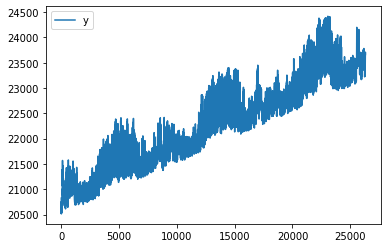

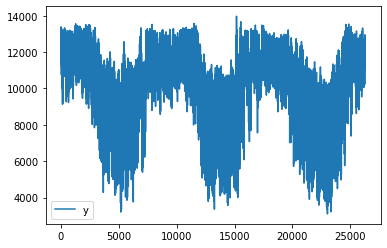

In [5]:
import numpy as np

df_global["y"] = (
    np.where(df_global["ID"] == "COAST", -df_global["y"], df_global["y"])
    + 2 * df_global[df_global["ID"] == "COAST"].mean().y
)
df_global["y"] = np.where(df_global["ID"] == "NORTH", df_global["y"] + 0.1 * df_global.index, df_global["y"])

df_global[df_global["ID"] == "NORTH"].plot()
df_global[df_global["ID"] == "COAST"].plot()

## Global Modeling

**Remark:**
- Training a time series only with trend and seasonality components can result in poor performance. The following example is used just to show the new local modelling of multiple time series functionallity.


In [6]:
import copy

df_global_cop = copy.copy(df_global)
df_global_cop["trend_smoothed"] = df_global_cop.groupby("ID")["y"].transform(
    lambda x: x.rolling(9000, 1, center=True).mean()
)
df_corr = df_global_cop[["ds"]]
for i in df_global_cop.ID.unique():
    df_corr = pd.merge(df_corr, df_global_cop[df_global_cop["ID"] == i][["ds", "trend_smoothed"]], how="left", on="ds")
    df_corr = df_corr.rename(columns={"trend_smoothed": i})
df_corr.corr().mean()

COAST      -0.666955
EAST        0.711579
FAR_WEST    0.692829
NORTH       0.684685
NORTH_C     0.712176
SOUTHERN    0.698006
SOUTH_C     0.717240
WEST        0.604039
dtype: float64

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error


def r2_rmse(g):
    r2 = r2_score(g["y"], g["yhat1"])
    rmse = np.sqrt(mean_squared_error(g["y"], g["yhat1"]))
    return pd.Series(dict(r2=r2, rmse=rmse))

### GLOBAL MODELING

In [8]:
m = NeuralProphet(
    trend_global_local="global",
    season_global_local="global",
    changepoints_range=0.8,
    epochs=10,
    trend_reg=5,
)

In [9]:
m.config_trend

Trend(growth='linear', changepoints=None, n_changepoints=10, changepoints_range=0.8, trend_reg=0.005, trend_reg_threshold=None, trend_global_local='global', glocal_trend_reg=0)

When a pd.DataFrame with an 'ID' column is the input for the `split_df` function, train and validation data are provided in a similar format. For global models, the input data is typically split according to a fraction of the time encompassing all time series (default when there is more than one 'ID' and when `local_split=False`). If the user wants to split each time series locally, the `local_split` parameter must be set to True. In this example, we will split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

In [64]:
df_train, df_test = m.split_df(df_global, valid_p=0.33, local_split=True)

After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

In [65]:
metrics = m.fit(df_train, freq="H")

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [66]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

In [67]:
# !pip install sklearn

In [68]:
forecast.dropna().groupby("ID").apply(r2_rmse).reset_index()

,ID,r2,rmse
0,COAST,-1.580939,3448.362826
1,EAST,0.362121,259.555309
2,FAR_WEST,0.448176,128.213144
3,NORTH,-7.464164,1243.631959
4,NORTH_C,0.321630,2747.489389
5,SOUTHERN,0.342286,496.176717
6,SOUTH_C,0.393488,1244.632351
7,WEST,0.214709,197.082303


In [69]:
test_metrics_global = m.test(df_test)
test_metrics_global

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([824])) that is different to the input size (torch.Size([824, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



,SmoothL1Loss,MAE,RMSE
0,0.055276,0.27629,0.319048


### LOCAL TREND SEASONALITY

We will repeat the process above, but for local modelling of trend and seasonality.

In [94]:
m = NeuralProphet(
    trend_global_local="local",
    season_global_local="local",
    changepoints_range=0.8,
    epochs=10,
    trend_reg=5,
)

In [95]:
metrics = m.fit(df_train, freq="H")

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [72]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

In [73]:
forecast.dropna().groupby("ID").apply(r2_rmse).reset_index()

,ID,r2,rmse
0,COAST,0.200881,1918.801160
1,EAST,0.582628,209.953193
2,FAR_WEST,0.465060,126.236377
3,NORTH,0.529835,293.106254
4,NORTH_C,0.548426,2241.646284
5,SOUTHERN,0.701957,334.008176
6,SOUTH_C,0.649932,945.578570
7,WEST,0.459639,163.483729


In [74]:
test_metrics_local = m.test(df_test)
test_metrics_local

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([824])) that is different to the input size (torch.Size([824, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



,SmoothL1Loss,MAE,RMSE
0,0.038028,0.21797,0.267939


 ### GLOCAL TREND SEASONALITY

In [96]:
m = NeuralProphet(
    trend_global_local="local",
    season_global_local="local",
    glocal_trend_reg=10,
    changepoints_range=0.8,
    epochs=10,
    trend_reg=5,
)

In [97]:
metrics = m.fit(df_train, freq="H")

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [98]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m.predict(future)

In [99]:
forecast.dropna().groupby("ID").apply(r2_rmse).reset_index()

,ID,r2,rmse
0,COAST,0.545439,1447.171830
1,EAST,0.568582,213.456752
2,FAR_WEST,0.507779,121.091055
3,NORTH,-2.925801,846.962144
4,NORTH_C,0.571705,2183.102742
5,SOUTHERN,0.680854,345.631015
6,SOUTH_C,0.647293,949.136419
7,WEST,0.462379,163.068656


In [100]:
test_metrics_local = m.test(df_test)
test_metrics_local

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([824])) that is different to the input size (torch.Size([824, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



,SmoothL1Loss,MAE,RMSE
0,0.042994,0.239699,0.286465


In [101]:
m.model.trend_deltas

Parameter containing:
tensor([[[ 2.6792e-02,  2.6614e-02,  2.6081e-02,  2.5213e-02,  2.3998e-02,
           2.6420e-02,  2.0728e-02,  1.8252e-02,  1.5920e-02,  1.2230e-02,
           8.7533e-03],
         [ 1.0594e-03,  1.0351e-03,  1.0395e-03,  1.0763e-03,  1.4944e-03,
           6.3421e-03,  2.4629e-03,  2.6917e-03,  2.4720e-03,  1.6452e-03,
           6.4804e-04],
         [ 1.7312e-03,  1.6757e-03,  1.6800e-03,  1.6825e-03,  1.9757e-03,
           6.3438e-03,  2.6892e-03,  2.9981e-03,  2.7671e-03,  1.3851e-03,
           7.3480e-04],
         [ 2.4285e-02,  2.4360e-02,  2.4646e-02,  2.5114e-02,  2.6025e-02,
           3.1294e-02,  2.8682e-02,  2.9714e-02,  2.6574e-02,  2.2567e-02,
           1.7927e-02],
         [-9.7772e-05, -9.6045e-05, -8.5261e-05, -6.3976e-05, -1.1938e-05,
           2.1283e-03,  8.6887e-06,  8.3045e-06,  2.5058e-05,  2.4677e-05,
           1.8737e-05],
         [ 2.1730e-04,  2.1678e-04,  1.4545e-04,  1.7446e-04,  3.5084e-04,
           4.3664e-03,  7.6711e-0

In [102]:
(m.model.trend_k0 - m.model.trend_k0.mean())

tensor([[[ 0.0021],
         [-0.0005],
         [-0.0002],
         [ 0.0017],
         [-0.0009],
         [-0.0004],
         [-0.0010],
         [-0.0008]]], grad_fn=<SubBackward0>)

In [103]:
(m.model.trend_deltas - m.model.trend_deltas.mean(-2)).pow(2).mean()

tensor(0.0001, grad_fn=<MeanBackward0>)

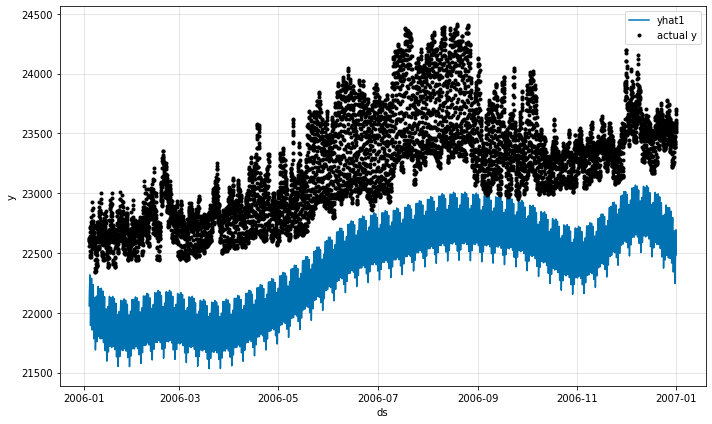

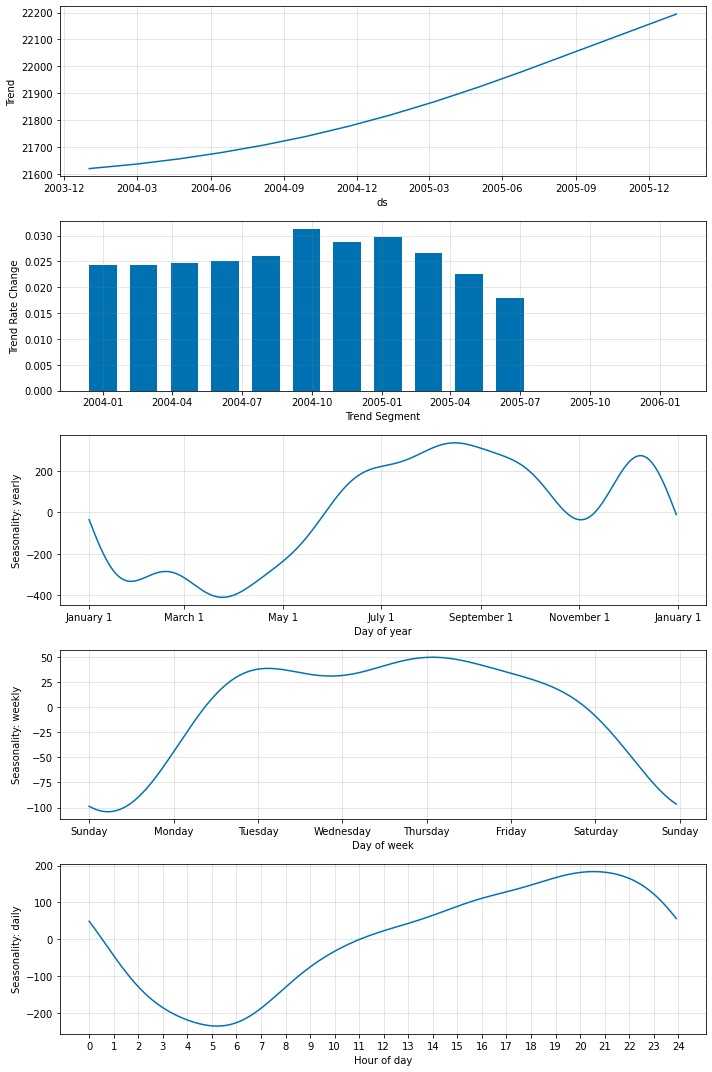

In [104]:
fig = m.plot(forecast[forecast["ID"] == "NORTH"])
fig_param = m.plot_parameters(df_name="NORTH")